In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
!pip install xgboost

In [4]:
!pip install shap


In [5]:
import sys
from pathlib import Path

# Assuming your notebook is in 'notebooks/' and 'uber_project/' is at the root
project_root = Path().resolve().parent  # <-- cambia según tu estructura
sys.path.append(str(project_root))

In [6]:
import pandas as pd
from config import FEATURES, TARGET, ID, DATE

pd.set_option('display.max_columns', None)

In [7]:
from transform import transform_features

In [8]:
df = pd.read_parquet('../../data/processed/BC_A&A_with_ATD_processed.parquet')
df.shape

(984241, 39)

In [9]:
df.head(2)

,region,territory,country_name,workflow_uuid,driver_uuid,delivery_trip_uuid,courier_flow,order_final_state_timestamp_local,eater_request_timestamp_local,geo_archetype,merchant_surface,pickup_distance,dropoff_distance,ATD,restaurant_offered_timestamp_local,order_hour,order_dayofweek,order_weekend,order_time_of_day,order_time_of_day_encoded,delivery_duration_minutes,preparation_time_minutes,delivery_hour,total_distance_km,distance_ratio,long_delivery_flag,courier_flow_encoded,geo_archetype_encoded,merchant_surface_encoded,territory_encoded,courier_flow_complexity_score,is_peak_hour,estimated_speed_kmh,is_short_trip_long_time,relative_prep_time,is_high_traffic_suspected,speed_below_threshold,rain,temp
0,Mexico,South East,Mexico,8c393c94-9282-41a6-a885-7a6e84b470d7,d16e401c-795d-4295-96c0-85ca08ad8c42,715f96aa-0a31-46f6-b856-6ea6f87affad,Motorbike,2025-04-06 13:48:48,2025-04-06 13:35:50,Drive momentum,Tablet,0.643,1.651,12.966667,2025-04-06 13:35:50,13,6,1,afternoon,0,12.966667,0.0,13,2.294,0.387116,0,2,2,2,3,1,1,7.639589,0,0.0,0,1,13.5,26.4
1,Mexico,South East,Mexico,b156dd16-274f-46d1-ac6f-4c24ca43df69,06299354-23ec-4173-83dc-d6bd32a420e1,ac985454-0e6f-4695-a68b-755c60c2afd7,Motorbike,2025-04-11 16:47:48,2025-04-11 16:30:56,Drive momentum,Tablet,0.812,1.733,16.866667,2025-04-11 16:30:56,16,4,0,afternoon,0,16.866667,0.0,16,2.545,0.465863,0,2,2,2,3,1,0,6.164822,0,0.0,0,1,13.5,26.4


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984241 entries, 0 to 984240
Data columns (total 39 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   region                              984241 non-null  object        
 1   territory                           984241 non-null  object        
 2   country_name                        984241 non-null  object        
 3   workflow_uuid                       984241 non-null  object        
 4   driver_uuid                         984241 non-null  object        
 5   delivery_trip_uuid                  984241 non-null  object        
 6   courier_flow                        984241 non-null  object        
 7   order_final_state_timestamp_local   984241 non-null  datetime64[ns]
 8   eater_request_timestamp_local       984241 non-null  datetime64[ns]
 9   geo_archetype                       984241 non-null  object        
 10  merchant

### Data Transformation

In [11]:
# Transform data for missing values and outliers
df_transformed = transform_features(df)
df_transformed.shape

(984240, 39)

In [12]:
final_df = df_transformed[[ID] + [DATE] + FEATURES + [TARGET]]
final_df.head(2)

,delivery_trip_uuid,restaurant_offered_timestamp_local,pickup_distance,dropoff_distance,order_hour,order_dayofweek,order_weekend,order_time_of_day_encoded,delivery_duration_minutes,preparation_time_minutes,delivery_hour,total_distance_km,distance_ratio,long_delivery_flag,courier_flow_encoded,geo_archetype_encoded,merchant_surface_encoded,territory_encoded,courier_flow_complexity_score,is_peak_hour,estimated_speed_kmh,is_short_trip_long_time,relative_prep_time,is_high_traffic_suspected,speed_below_threshold,rain,temp,ATD
0,715f96aa-0a31-46f6-b856-6ea6f87affad,2025-04-06 13:35:50,0.643,1.651,13,6,1,0,12.966667,0.0,13,2.294,0.387116,0,2,2,2,3,1,1,7.639589,0,0.0,0,1,13.5,26.4,12.966667
1,ac985454-0e6f-4695-a68b-755c60c2afd7,2025-04-11 16:30:56,0.812,1.733,16,4,0,0,16.866667,0.0,16,2.545,0.465863,0,2,2,2,3,1,0,6.164822,0,0.0,0,1,13.5,26.4,16.866667


### Preprocessing for train and test

In [13]:
df = final_df.copy()

In [14]:
df.shape

(984240, 28)

In [15]:
df[DATE] = pd.to_datetime(df[DATE])

# Dividimos por tiempo: marzo = train, abril = test
train_df = df[df[DATE].dt.month == 3]
test_df = df[df[DATE].dt.month == 4]

# Variables
DROP_COLS = [ID, DATE, TARGET]

X_train = train_df.drop(columns=DROP_COLS)
y_train = train_df[TARGET]

X_test = test_df.drop(columns=DROP_COLS)
y_test = test_df[TARGET]

### Model Training

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"\\n{name} Results:")
    print(f"MAE: {{mae:.2f}}, RMSE: {{rmse:.2f}}, R²: {{r2:.2f}}")
    return name, mae, rmse, r2

results = []

models = [
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
    ("LightGBM", LGBMRegressor(n_estimators=100, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
]

for name, model in models:
    results.append(evaluate_model(name, model, X_train, y_train, X_test, y_test))


/opt/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


\nLinearRegression Results:
MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}
\nRandomForest Results:
MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2148
[LightGBM] [Info] Number of data points in the train set: 577791, number of used features: 25
[LightGBM] [Info] Start training from score 37.326610
\nLightGBM Results:
MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}
\nXGBoost Results:
MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}


### Models comparison

In [17]:
result_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
result_df.sort_values("MAE")

,Model,MAE,RMSE,R2
1,RandomForest,0.008358,0.197159,0.999876
2,LightGBM,0.149544,0.382433,0.999534
3,XGBoost,0.186796,0.467376,0.999304
0,LinearRegression,6.220436,10.036871,0.678862


Observations:

* RandomForest is the best model:
    * Better performance overall
    * MAE and RMSE are the lowest one 
    * R2 is almost 1

### Saving best model

In [18]:
import joblib

# Supongamos que 'best_model' es el RandomForest entrenado
best_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
best_model.fit(X_train, y_train)

# Guardar el modelo
joblib.dump(best_model, 'random_forest_model.pkl')
print("Modelo guardado exitosamente.")

#To read the model for further predictions
#loaded_model = joblib.load('random_forest_model.pkl')

Modelo guardado exitosamente.


### Prediction Visualization

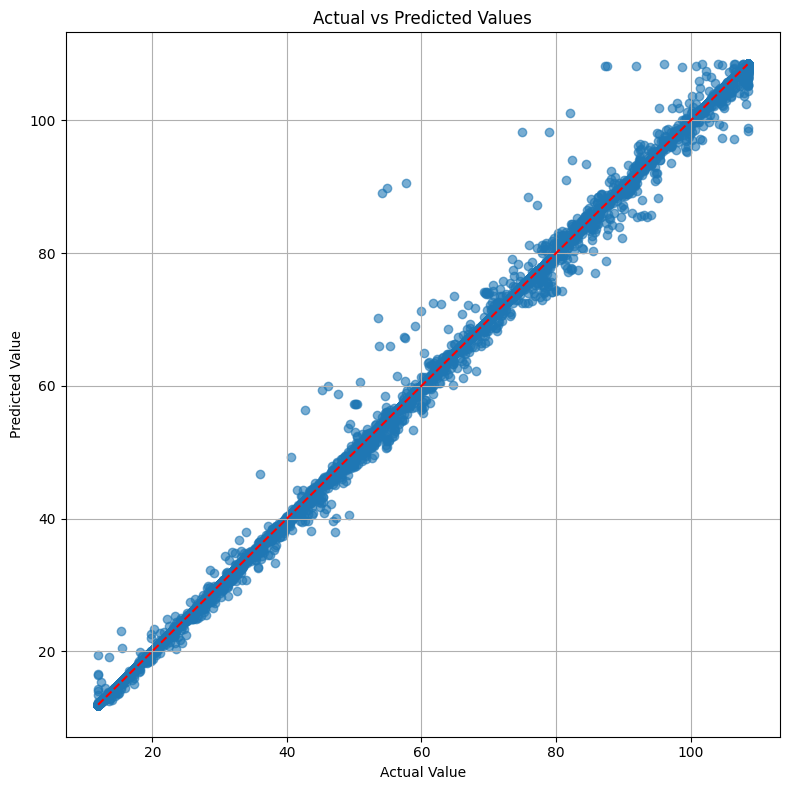

In [19]:
import matplotlib.pyplot as plt

preds = best_model.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea de referencia perfecta
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


### Feature Importance

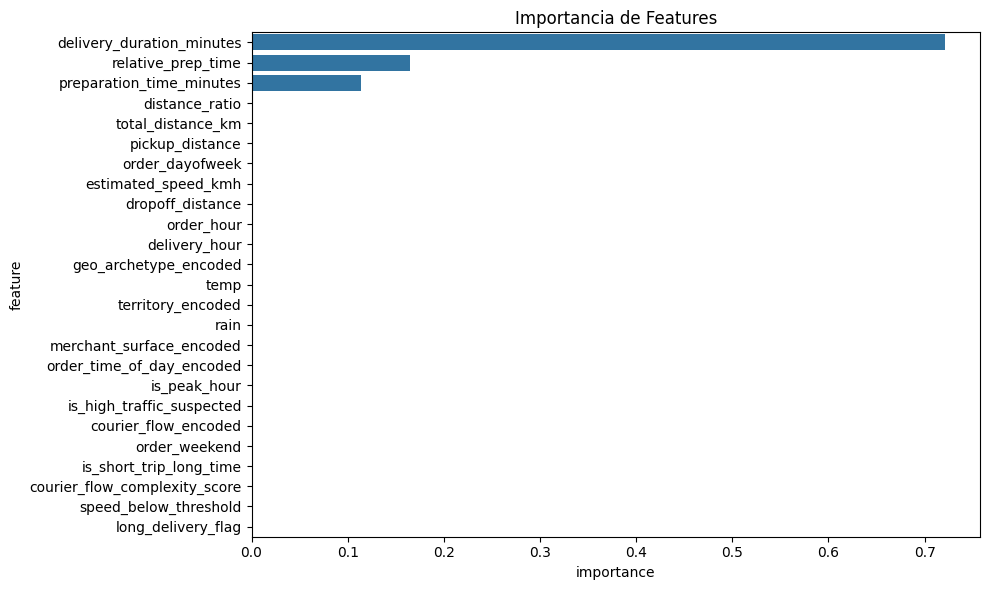

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Obtener importancia
importances = best_model.feature_importances_
feature_names = X_train.columns

# Crear dataframe
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

# Graficar
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df, x='importance', y='feature')
plt.title('Importancia de Features')
plt.tight_layout()
plt.show()


# Experiment 1 (With weather variables)

# Experiment 2